In [1]:
%pylab inline
%matplotlib inline

from IPython.display import display, Markdown, HTML
from matplotlib import animation, rc

from os.path import join
from os import remove
import sys
from subprocess import Popen, PIPE

from datetime import datetime, timedelta
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import cv2

import numpy as np
from scipy import misc

logging.info('Python version: %s' % sys.version)
logging.info('CV2 version: %s' % cv2.__version__)

INFO:root:Python version: 2.7.11 |Anaconda custom (64-bit)| (default, Jun 15 2016, 15:21:30) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
INFO:root:CV2 version: 3.2.0


Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
# Static params (change is not recommended)
OBSERVED_VALUE = 0
IMAGE_SHAPE = (512,512)

# Dynamic params (feel free to play around)
SAVE_VID = True  # False implies showing the video inline via matplotlib
THRESH = 40
INTERVAL_MSECS = 3
FRAMES = 20000
FPS = 166

## Sources

In [3]:
IMG_NAME = 'or'
PROJECT_ROOT = '/home/dsteam/repos/face-it/'
IMG_PATH = 'painter/examples/%s.jpg' % IMG_NAME
XML_PATH = 'painter/data/haarcascade_frontalface_alt.xml'
TMP_PATH = 'painter/examples/%s_tmp.jpg' % IMG_NAME
MP4_PATH = 'painter/videos/%s.mp4' % IMG_NAME
GIF_PATH = 'painter/videos/%s.gif' % IMG_NAME
IMAGE_PREPRO = 'painter/image_preprocessor.py'

image_path = join(PROJECT_ROOT, IMG_PATH)
xml_path = join(PROJECT_ROOT, XML_PATH)
tmp_path = join(PROJECT_ROOT, TMP_PATH)
image_prepro = join(PROJECT_ROOT, IMAGE_PREPRO)
mp4_path = join(PROJECT_ROOT, MP4_PATH)
gif_path = join(PROJECT_ROOT, GIF_PATH)

In [4]:
# Dependecies imports
sys.path.extend([PROJECT_ROOT,])
from painter.saliency.vid_painter import Painter
from painter.saliency.mrf import grid2mat, build_grid_graph
from painter.saliency.saliency_map import api as saliency_map

## Preprocess

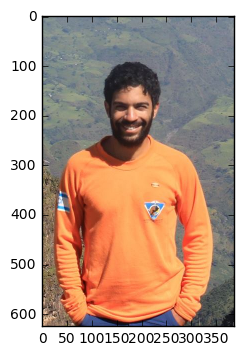

In [5]:
# read image
rgb_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) # misc.imread(image_path)
gray_image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
plt.imshow(misc.imread(image_path))

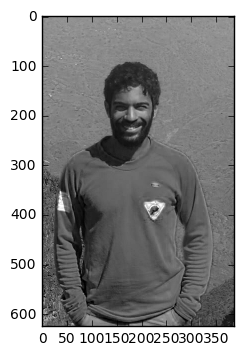

In [6]:
plt.imshow(gray_image[:,:,0], 'gray')

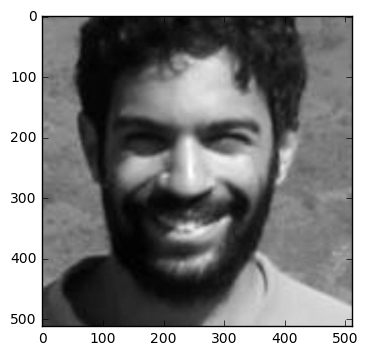

In [8]:
# manual tests
MANUAL = False
assert(MANUAL in [False, 'part', 'rescale'])

if MANUAL is False:
    # Apply Facial Regocnition to focus image at a face, and resize to IMAGE_SHAPE
    cmnd = "source activate image_pp; %s --image='%s' --grey='%s' --xml='%s'; source deactivate" % (image_prepro, image_path, tmp_path, xml_path)
    process = Popen(cmnd, shell=True, stdout=PIPE)
    process.wait()
    
    image_segment = cv2.imread(tmp_path)  # misc.imread(image_path)
    plt.imshow(misc.imread(tmp_path), 'gray')
    
    # delete tmp file
    try:
        remove(tmp_path)
    except OSError:
        pass
else: 
    if MANUAL=='part':
        # Choose part manualy
        square_size = 800
        lowerleft = ((gray_image.shape[0] - square_size) / 2, (gray_image.shape[1] - square_size) / 2)
        upperright = (lowerleft[0] + square_size, lowerleft[1] + square_size)
        image_segment = gray_image[lowerleft[0]:upperright[0], lowerleft[1]:upperright[1],:]
        image_segment = cv2.resize(image_segment, (512, 512))
    else:
        if MANUAL=='rescale':
            image_segment = cv2.resize(gray_image, (512, 512))

    plt.imshow(image_segment[:,:,0], 'gray')

## Generate MRF

In [ ]:
painter = Painter(image_segment, dist_scale_thresh=THRESH, image_shape=IMAGE_SHAPE, observed_value=OBSERVED_VALUE)
frame_gen = painter.frame_gen()

fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)  # try
plt.axis('off')

blank_img = np.multiply(np.ones(IMAGE_SHAPE), 255).astype(np.int)
blank_img[0] = 0  # hack to prevent plt from presenting a black figure
im = plt.imshow(blank_img, 'gray', animated=True)  # figimage
plt.close(fig)
cur_frame, frame_cntr = None, 0

def updatefig(*args):
    global frame_cntr
    frame_cntr += 1
    if frame_cntr % 1000 == 0:
        logging.info('**********Recoded frame number %d**********' % frame_cntr)
    try:
        cur_frame = frame_gen.next()
    except StopIteration:
        pass
    im.set_array(cur_frame)
    return im,

# record video and save/inline
ani = animation.FuncAnimation(fig, updatefig, frames=FRAMES, interval=INTERVAL_MSECS, blit=True)
if SAVE_VID:
    writer = animation.FFMpegWriter(FPS)
    ani.save(mp4_path, writer=writer)
else:
    rc('animation', html='html5')
    display(ani)

# convert MP4 to GIF:
try:
    
    # 'ffmpeg -i %s -vf scale=320:-1 -r 10 -f image2pipe -vcodec ppm - | convert -delay 5 -loop 0 - %s'  #  ON LINUX
    # 'ffmpeg -i %s %s -hide_banner'  #  ON WINDOWS
    # ffmpeg -i 1.mp4 -filter:v "setpts=PTS/40,scale=320:-1" -t 60 60.gif
    cmnd = 'ffmpeg -i %s -filter:v "setpts=PTS/40,scale=512:-1" -t 60  %s' % (mp4_path, gif_path)
    process = Popen(cmnd, shell=True, stdout=PIPE)
    process.wait()
except Exception as e:
    logging.ERROR('Failed to convert mp4 to gif')
    raise e